# Семинар 7: временные ряды II

## Вступление
В первой части мы консолидируем полученные на прошлом семинаре знания, и разберем end-to-end решение модельной задачи при помощи [ETNA](https://etna.tinkoff.ru/), подготовленное одним из разработчиков библиотеки Максимом Жерело (Тинькофф). Во второй части семинара мы разберем то, как с задачей прогнозирования рядов справляются современные трансформерные архитектуры; эта часть семинара задействует HuggingFace Transformers в связке с GluonTS от Amazon. Она является адаптацией соответствующего [туториала](https://huggingface.co/blog/time-series-transformers)

NB1: Перед установкой ноутбука убедитесь, что у вас установлен Python 3.9: ноутбук был прогнан на версии 3.9.16, на более старших версиях может ломаться.

NB2: у ETNA есть группа в тг на предмет вопросов, в том числе по проведенной коллегами лекции: https://t.me/etna_support

### План семинара <a class="anchor" id="menu"></a>
* [End-to-end пайнлайн для модельной задачи](#chapter1)
* [Глубинное обучение (трансформеры) для временных рядов](#chapter2)

In [ ]:
# !pip install -r requirements.txt

In [1]:
pip install ujson

Note: you may need to restart the kernel to use updated packages.


In [2]:
from copy import deepcopy
import warnings

import gdown
import os
import zipfile

import torch
import random
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from functools import lru_cache
from functools import partial

from typing import Optional
from typing import Iterable

from torch.optim import AdamW
from torch.utils.data import DataLoader

from datasets import load_dataset
from accelerate import Accelerator
from evaluate import load

from transformers import (
    TimeSeriesTransformerConfig, 
    TimeSeriesTransformerForPrediction,
    PretrainedConfig
)

from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.models import LinearPerSegmentModel

from etna.metrics import SMAPE, MAPE, MAE, MSE
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import STLTransform
from etna.transforms import DensityOutliersTransform
from etna.transforms import DateFlagsTransform

from etna.analysis import (
    plot_backtest, plot_residuals, 
    acf_plot, get_residuals, 
    plot_anomalies, stl_plot
)

from etna.analysis.outliers import get_anomalies_density

from gluonts.transform.sampler import InstanceSampler
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset

from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_seasonality,
    get_lags_for_frequency
)

from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

warnings.filterwarnings("ignore")

#from transformers import PretrainedConfig
#from gluonts.time_feature import get_seasonality
#from gluonts.time_feature import get_lags_for_frequency
#from gluonts.time_feature import time_features_from_frequency_str

In [4]:
url = 'https://drive.google.com/file/d/1vw7qfMwE5jq7x-ErgskpEAcqiSEUP49S/view?usp=share_link'
output = 'data.zip'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
os.remove('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1vw7qfMwE5jq7x-ErgskpEAcqiSEUP49S
To: /Users/andreiegorov/Desktop/data.zip
100%|██████████████████████████████████████| 5.77k/5.77k [00:00<00:00, 6.06MB/s]


# 1. Модельная задача <a class="anchor" id="chapter1"></a>
[Назад к меню](#menu)

In [5]:
NFOLDS = 40

sns.reset_orig()

В первой части семинара предлагается консолидировать знания, полученные на предыдущем семинаре, а также расширить их рядом полезных дополнительных приемов. Для этой цели мы построим полный пайплайн прогнозирования временного ряда из набора данных `seminar_data.csv`. 

## 1.1. Чтение данных

In [6]:
df = pd.read_csv("data.csv")
df.head()

,f_0,f_1,f_2,f_3,target,segment,timestamp
0,-0.196658,-0.381908,-0.463617,-1.036998,5.122664,main,2020-01-01
1,-0.649385,-1.220483,0.310150,-1.846336,5.548333,main,2020-01-02
2,-0.962326,-0.975947,1.687106,-2.816835,5.423648,main,2020-01-03
3,-1.219058,-0.493233,2.375747,-4.381200,4.871951,main,2020-01-04
4,-0.865619,-0.900665,0.744983,-4.036739,4.650783,main,2020-01-05


В загруженном датафрейме 7 колонок:
- `target` - целевая переменная, задача семинара построить модель прогнозирования данного ряда;
- `f_i` - временные ряды, которые могут быть использованы для анализа или в качестве признаков в моделях;
- `segement` - название сегмента для моделирования, в данной задаче принимает единственное значение `main`;
- `timestamp` - временная метка.

## 1.2. EDA

Посмотрим, есть ли в данных пропуски.

In [7]:
df.isna().sum(axis=0)

f_0          0
f_1          0
f_2          0
f_3          0
target       1
segment      0
timestamp    0
dtype: int64

Изучим базовые статистики рядов.

In [8]:
df.describe()

,f_0,f_1,f_2,f_3,target
count,100.000000,100.000000,100.000000,100.000000,99.000000
mean,3.070329,0.398380,2.118071,-1.127272,16.364582
std,2.263931,2.540592,2.859025,7.245372,15.231086
min,-1.431537,-4.745966,-1.739895,-12.323881,1.345481
25%,1.387638,-1.334088,0.287262,-8.302886,5.748214
50%,2.935997,0.156904,0.872667,-3.003978,9.032371
75%,4.472277,2.443423,3.228293,6.345087,23.057769
max,9.181458,5.043954,9.748184,10.404256,70.780019


Можно отметить, что целевая переменная принимает только положительные значения.

Построим графики рядов.

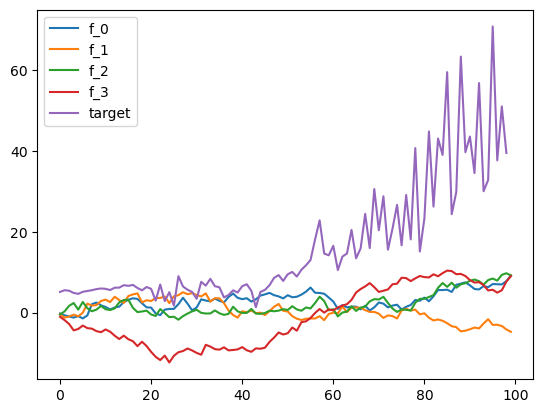

In [9]:
df.plot();

Из графика можно сделать предположение о наличии тренда в целевой переменной, а также возможное наличие выбросов
и периодичности.

Изучим совместные распределения рядов.

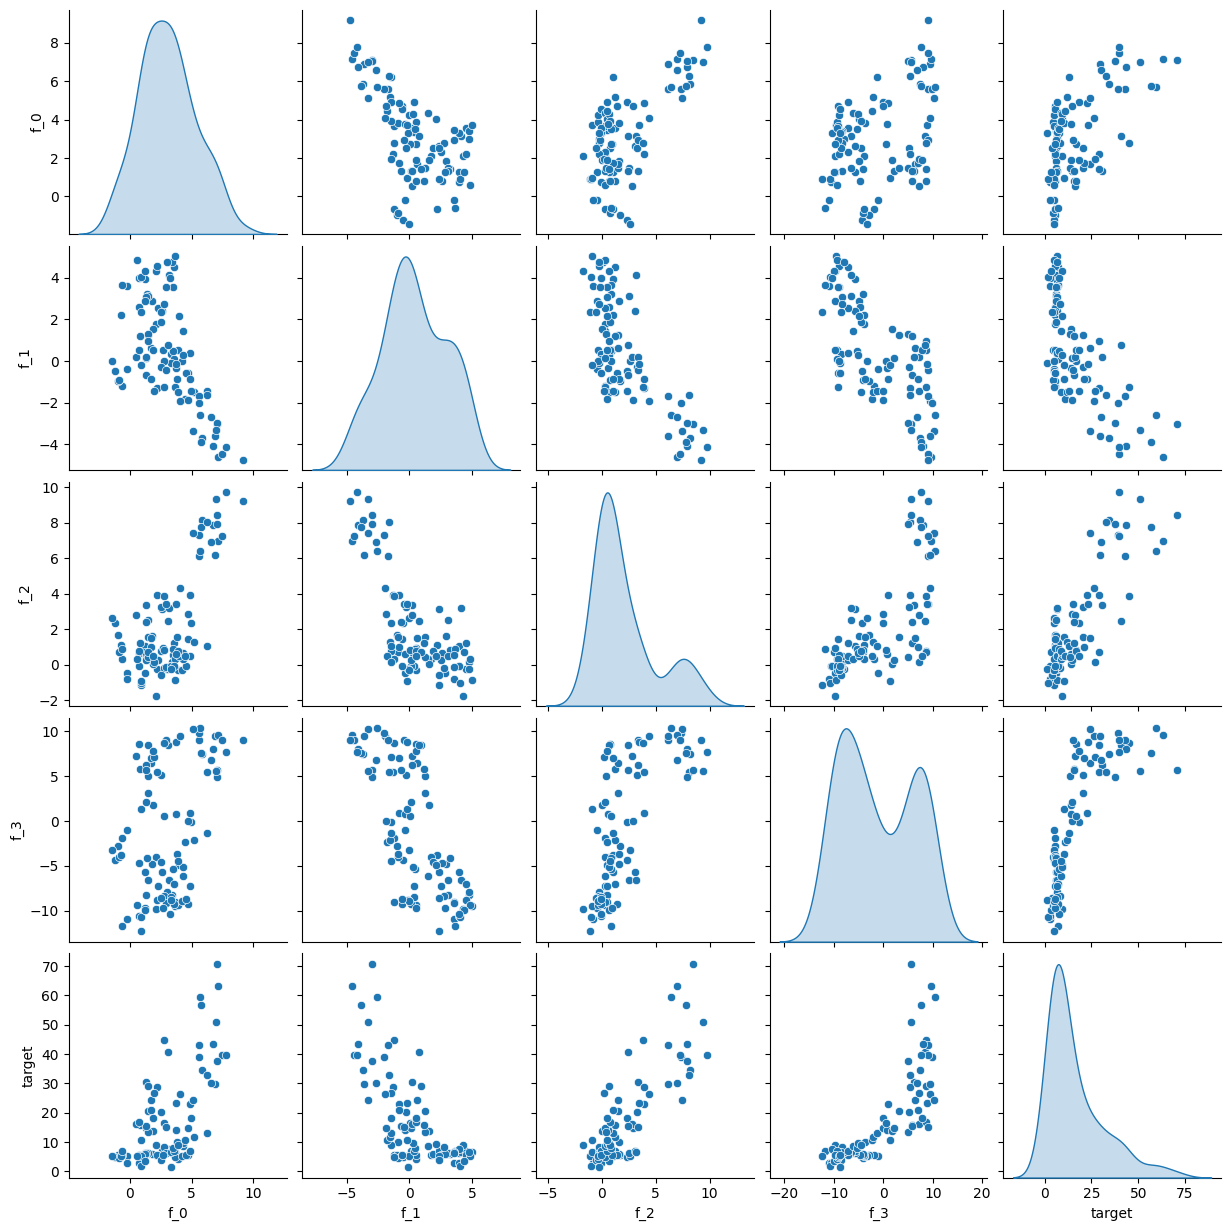

In [7]:
sns.pairplot(df, diag_kind="kde");

Из графика нельзя сделать однозначного предположения о распределении рядов. Однако, можно отметить наличие корреляции в данных.
Посмотрим ближе на данную статистику

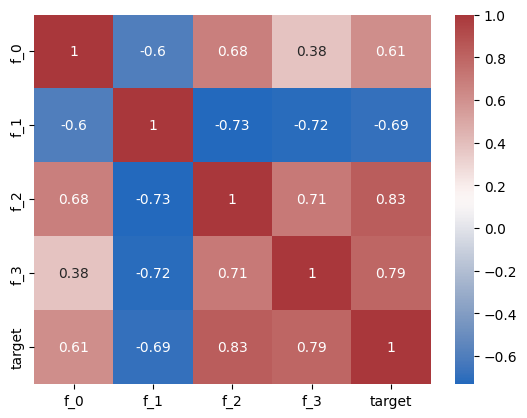

In [8]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

Отметим наличие линейной зависимости между переменными `f_i` и целевой переменной.

## 1.3. Подготовка данных

Как обычно, перед началом моделирования данные необходимо подготовить. Приведём ряды в удобный для
библиотеки ETNA формат и избавимся от пропусков.

In [9]:
df_target = TSDataset.to_dataset(df=df[["target", "segment", "timestamp"]])
df_target.dropna(inplace=True)
df_target

segment,main
feature,target
timestamp,
2020-01-01,5.122664
2020-01-02,5.548333
2020-01-03,5.423648
2020-01-04,4.871951
2020-01-05,4.650783
...,...
2020-04-04,32.821104
2020-04-05,70.780019


In [10]:
df_exog = TSDataset.to_dataset(df=df.drop(columns=["target"]))
df_exog

segment         main                              
feature          f_0       f_1       f_2       f_3
timestamp                                         
2020-01-01 -0.196658 -0.381908 -0.463617 -1.036998
2020-01-02 -0.649385 -1.220483  0.310150 -1.846336
2020-01-03 -0.962326 -0.975947  1.687106 -2.816835
2020-01-04 -1.219058 -0.493233  2.375747 -4.381200
2020-01-05 -0.865619 -0.900665  0.744983 -4.036739
...              ...       ...       ...       ...
2020-04-05  7.084863 -3.025939  8.439371  5.658169
2020-04-06  7.025304 -2.993193  7.920864  4.947350
2020-04-07  6.986553 -3.294862  9.351569  5.534719
2020-04-08  7.790249 -4.155614  9.748184  7.685552
2020-04-09  9.181458 -4.745966  9.210712  9.041758

[100 rows x 4 columns]

Как мы помним, для работы с данными в ETNA есть специальная сущность -- `TSDataset`. Передадим подготовленные данные в конструктор сущности.

In [11]:
train_ts = TSDataset(df=df_target, df_exog=df_exog, known_future="all", freq="D")
train_ts

segment         main                                         
feature          f_0       f_1       f_2       f_3     target
timestamp                                                    
2020-01-01 -0.196658 -0.381908 -0.463617 -1.036998   5.122664
2020-01-02 -0.649385 -1.220483  0.310150 -1.846336   5.548333
2020-01-03 -0.962326 -0.975947  1.687106 -2.816835   5.423648
2020-01-04 -1.219058 -0.493233  2.375747 -4.381200   4.871951
2020-01-05 -0.865619 -0.900665  0.744983 -4.036739   4.650783
...              ...       ...       ...       ...        ...
2020-04-04  6.290445 -1.617311  8.055428  5.491064  32.821104
2020-04-05  7.084863 -3.025939  8.439371  5.658169  70.780019
2020-04-06  7.025304 -2.993193  7.920864  4.947350  37.666134
2020-04-07  6.986553 -3.294862  9.351569  5.534719  51.027200
2020-04-08  7.790249 -4.155614  9.748184  7.685552  39.493580

[99 rows x 5 columns]

## 1.4. Построение базового пайплайна прогнозирования

Для обучения и валидации модели будем использовать знакомую нам сущность `Pipeline`.
В целом, использование `Pipeline` позволит ускорить и упростить обучение и тестирование модели.
Например, разбиение на тренировочные и тестовые выборки при запуске кросс валидации в таком случае будет производиться автоматически.

(Reminder) `Pipeline` имеет несколько параметров:
- `model` - модель, которая будет обучаться и тестироваться;
- `horizon` - горизонт прогнозирования;
- `transforms` - список преобразований, которые нужно применить к данным.

Ещё одним достоинством использования пайплайна является автоматическое прямое и обратное преобразование данных, следовательно,
о согласованности данных можно не беспокоиться. Кросс валидацию на исторических данных можно запустить с помощью метода `backtest`.

Для оценки качества модели на этот раз будем использовать среднюю квадратичную ошибку (`MSE`) и среднее абсолютное отклонение (`MAE`).

В качестве бэйзлайна возьмём линейную модель на признаках из набора данных.
Поскольку задачей моделирования является прогнозирования единственного целевого ряда воспользуемся `LinearPerSegmentModel`.

In [12]:
pipeline = Pipeline(model=LinearPerSegmentModel())
metrics, forecast, _ = pipeline.backtest(ts=train_ts, metrics=[MAE(), MSE()], n_folds=NFOLDS, aggregate_metrics=True)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.9s finished


,segment,MAE,MSE
0,main,7.970842,120.778685


Построим график прогноза.

Результаты бэктеста модели могут быть построены с помощью функции `plot_backtest`.

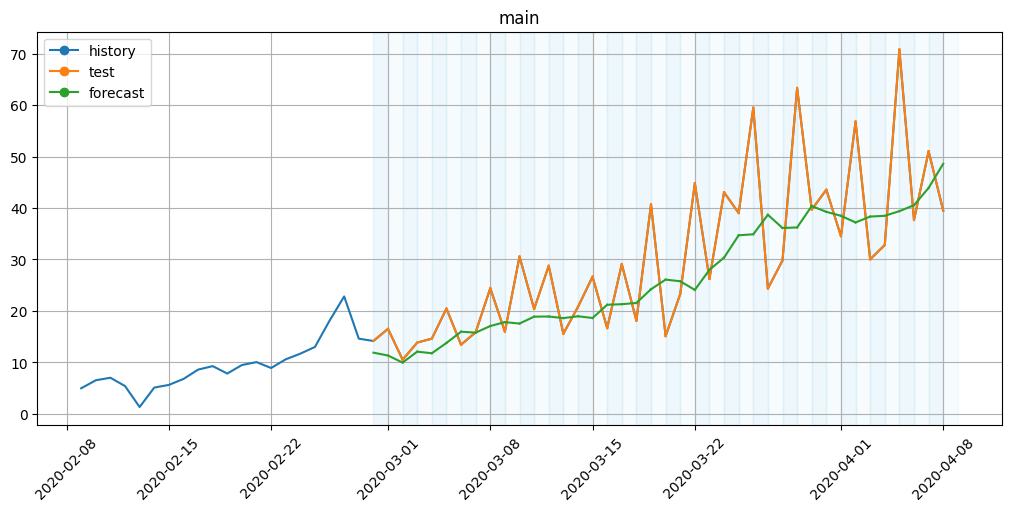

In [13]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20)

Модели удалось спрогнозировать общее направление тренда. Однако особенности ряда не были учтены.
Также можно отметить наличие смещения в прогнозе.

Посмотрим на остатки прогноза.

Resids: mean=3.877427011487634, std=10.41420357653484


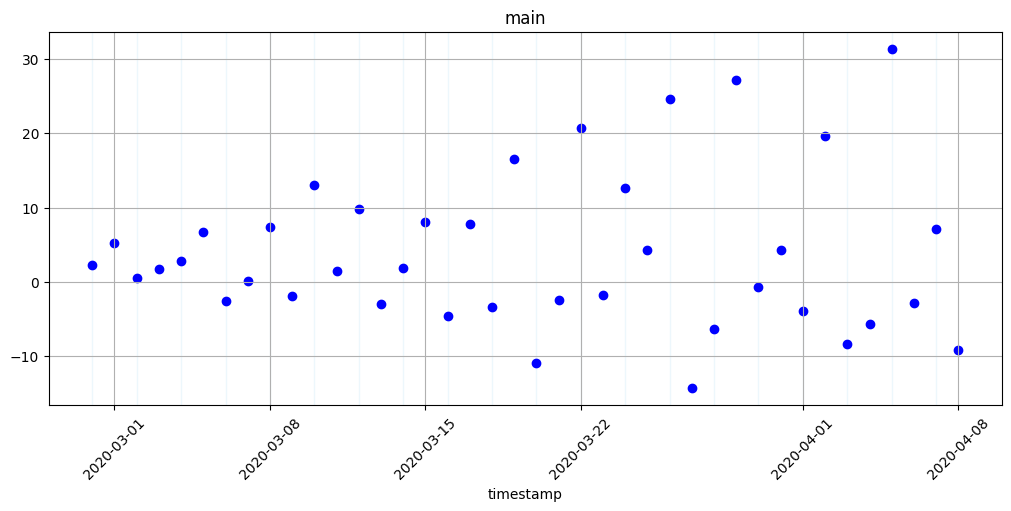

In [14]:
resids = get_residuals(forecast_df=forecast, ts=train_ts)

print(f'Resids: mean={resids[:, :, "target"].mean().item()}, std={resids[:, :, "target"].std().item()}')
plot_residuals(forecast_df=forecast, ts=train_ts)

В остатках наблюдается увеличение дисперсии с течением времени.

Из результатов можно предположить наличие неучтённой лаговой зависимости в целевом ряду. Для проверки гипотезы построим
график автокорреляции для остатков.

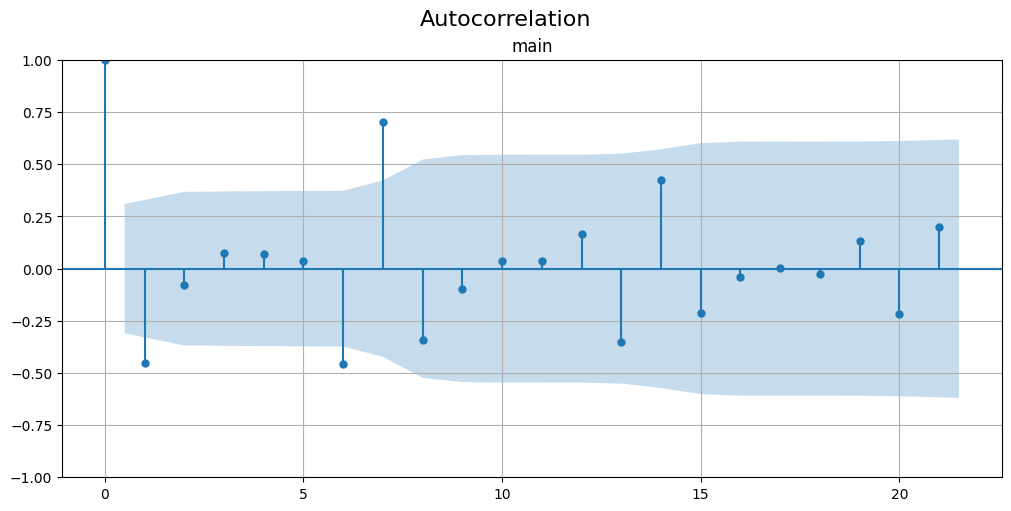

In [15]:
acf_plot(resids)

В остатках наблюдается автокорреляция, при этом наиболее значимым является 7 лаг.

## 1.5. Тренд и лаговые переменные

Для учёта тренда в модели воспользуемся `LinearTrendTransform`. Также добавим лаг в модель с помощью `LagTransform`.
Список необходимых преобразований передаётся напрямую в `Pipeline`. В таком случае прямые и обратные
преобразования будут производиться автоматически.

In [16]:
pipeline = Pipeline(
    transforms=[
        LinearTrendTransform(in_column="target"),
        LagTransform(in_column="target", lags=[7])
    ],
    model=LinearPerSegmentModel()
)
metrics, forecast, _ = pipeline.backtest(ts=train_ts, metrics=[MAE(), MSE()], n_folds=NFOLDS, aggregate_metrics=True)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.1s finished


,segment,MAE,MSE
0,main,5.383472,45.882554


Добавление преобразований позволило значительно улучшить качество модели.

Посмотрим на результаты прогноза.

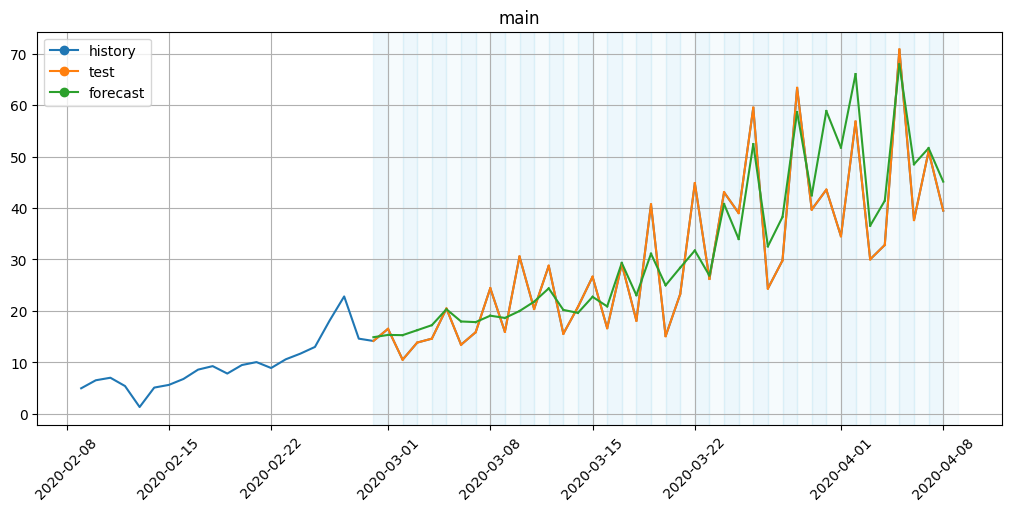

In [17]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20)

Наличие тренда и лаговой зависимости в модели позволило избавиться от смещения прогноза, а также лучше учитывать особенности ряда.
Однако периодичность ряда была смоделирована не полностью.

Построим график остатков прогноза.

Resids: mean=-1.8205069013787991, std=6.607556588585315


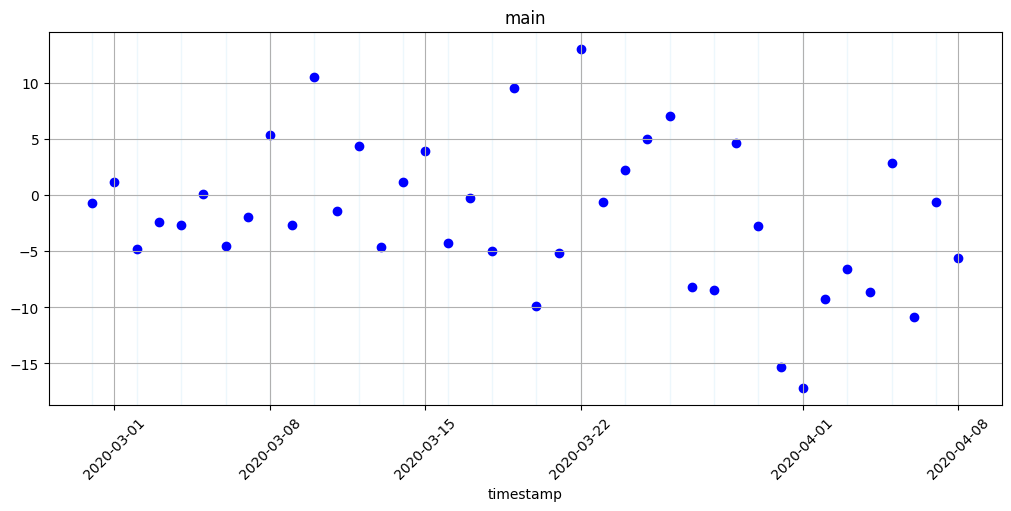

In [18]:
resids = get_residuals(forecast_df=forecast, ts=train_ts)

print(
    f'Resids: mean={resids[:, :, "target"].mean().item()}, \
    std={resids[:, :, "target"].std().item()}'
)

plot_residuals(forecast_df=forecast, ts=train_ts)

Динамика дисперсии ряда все еще учтена не полностью.

## 1.6. Моделирование сезонности

Результаты предыдущих моделей могут свидетельствовать о наличии тренда и сезонности.

Для учёта данных эффектов воспользуемся STL декомпозицией.

> STL - Seasonal and Trend decomposition using LOESS <br>
<br>
> LOESS (locally estimated scatterplot smoothing) - непараметрический метод, использующий обучение полиномиальной регрессии (относительно невысокой степени) на последовательных скользящих окнах. Другими словами, мы обучаем несложные модели на последовательных подвыборках данных, и точка за точкой конкатенируем получаемые результаты. Таким образом, мы можем выделить основную тенденцию ряда, не делая никаких изначальных предпосылок о данных. Другое название - фильтр Савицкого-Голея.

Данный метод позволяет выделить из ряда трендовую и сезонную составляющие. Достоинствами метода являются возможность работы с различными периодами сезонности, а также контроль над гладкостью сезонных циклов и устойчивостью к выбросам.

Построим график STL разложения, установив период сезонности равным 7.

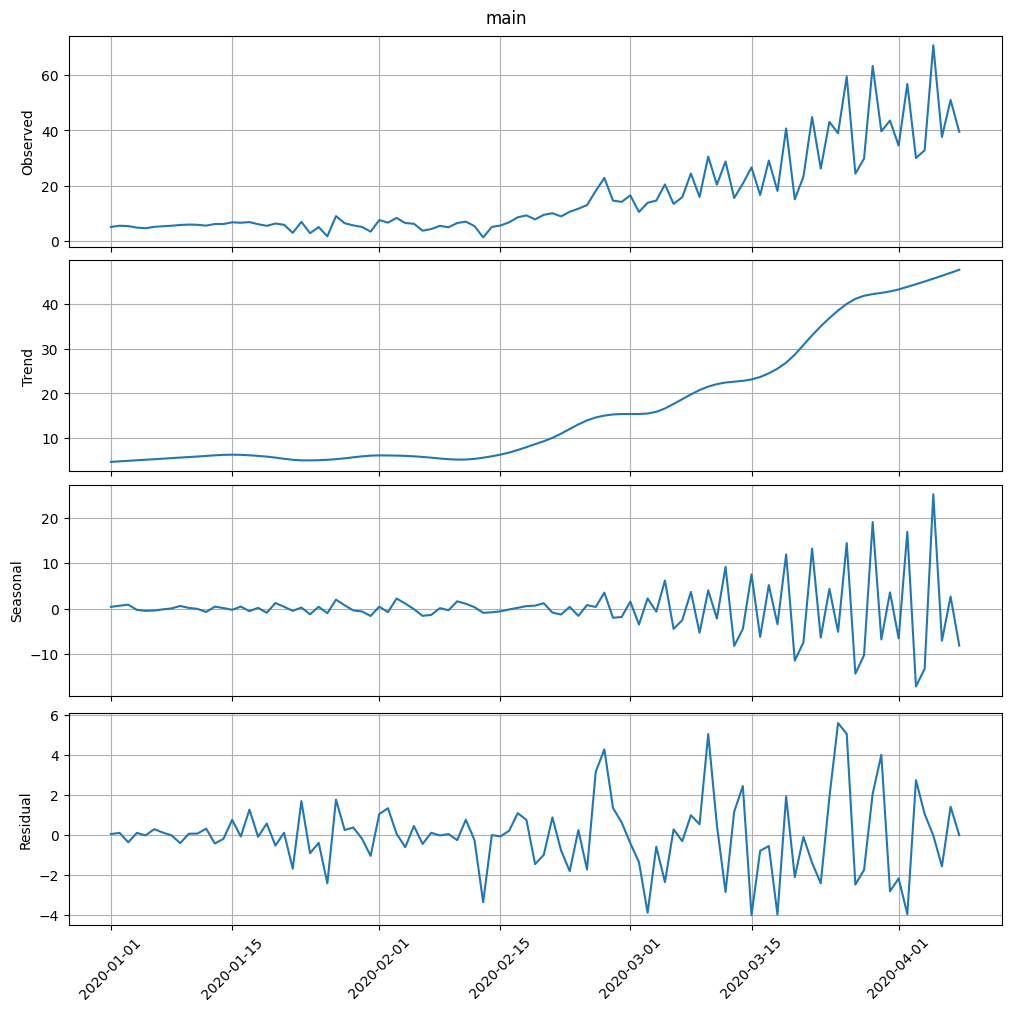

In [19]:
stl_plot(ts=train_ts, period=7)

Добавим `STLTransform` в пайплайн и построим новую модель.

In [20]:
pipeline = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
    ],
    model=LinearPerSegmentModel()
)
metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, 
    metrics=[MAE(), MSE()], 
    n_folds=NFOLDS, 
    aggregate_metrics=True
)

metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.1s finished


,segment,MAE,MSE
0,main,4.941858,39.395582


Отметим, что использование STL декомпозиции позволило улучшить качество прогноза.

Проанализируем результаты прогноза.

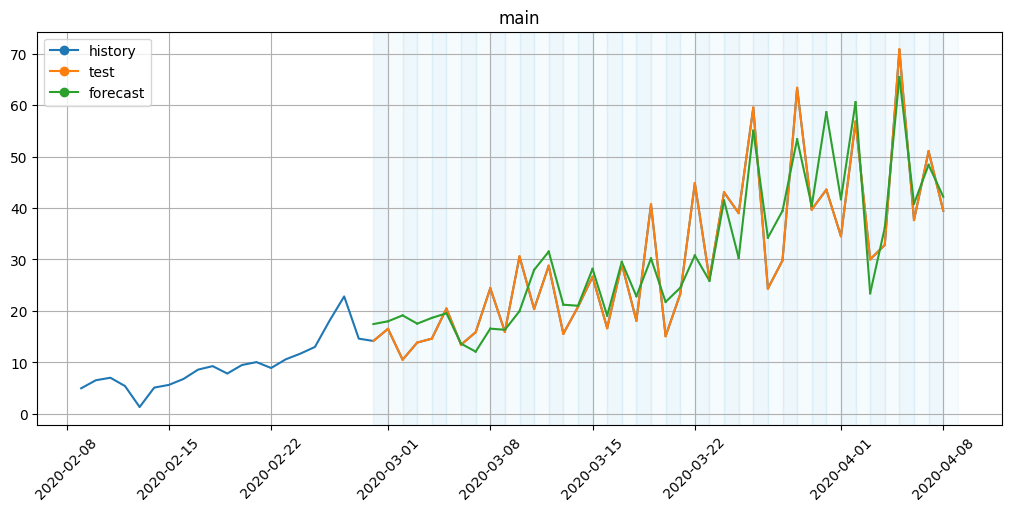

In [21]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20)

Resids: mean=-0.5707105893866948, std=6.330218239380606


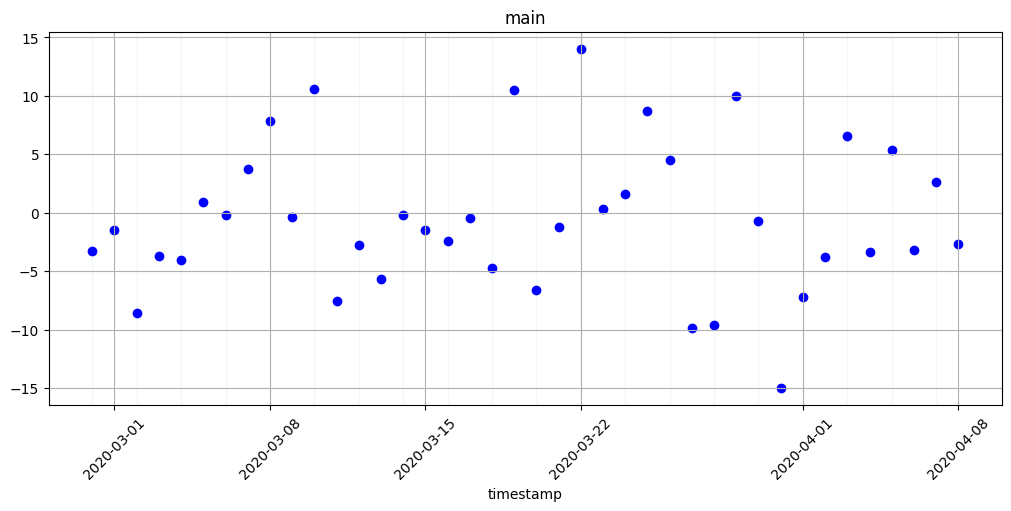

In [22]:
resids = get_residuals(forecast_df=forecast, ts=train_ts)

print(
    f'Resids: mean={resids[:, :, "target"].mean().item()}, \ 
    std={resids[:, :, "target"].std().item()}'
)

plot_residuals(forecast_df=forecast, ts=train_ts)

Полученная модель намного лучше учитывает динамику целевой переменной, однако можно заметить несколько выделяющихся наблюдений.

Построим график автокорреляции остатков.

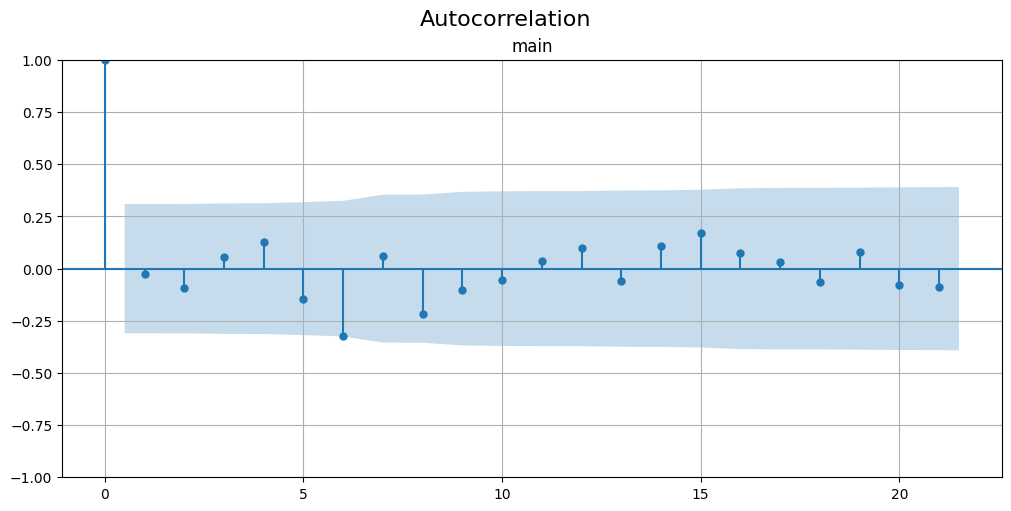

In [23]:
acf_plot(resids)

Значимой автокорреляции не наблюдается.

## 1.7. Анализ аномалий

Предположим наличие аномалий в данных. Поиск будем осуществлять на основе локальной плотности.
Как мы помним, в библиотеке данный метод реализован в функции `get_anomalies_density`. `DensityOutliersTransform` -- соответствущее
преобразование для пайплайна.

Посмотрим какие точки были выбраны в качестве выбросов после применения STL декомпозиции.

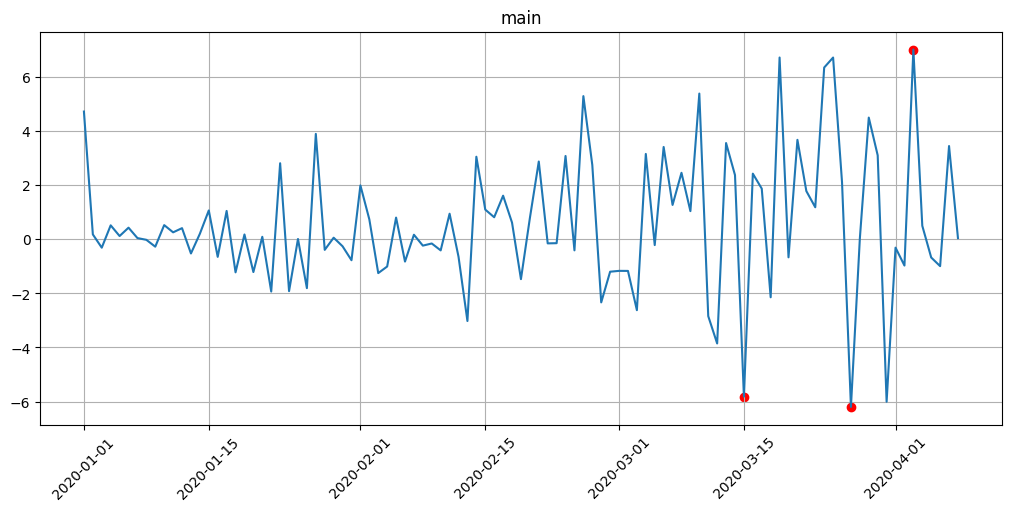

In [24]:
transformed_train_ts = deepcopy(train_ts)
transformed_train_ts.fit_transform([
    STLTransform(in_column="target", period=7, model="arima")
])

plot_anomalies(
    ts=transformed_train_ts,
    anomaly_dict=get_anomalies_density(ts=transformed_train_ts, window_size=5),
)

Проверим отсутствие автокорреляции в данных после преобразования.

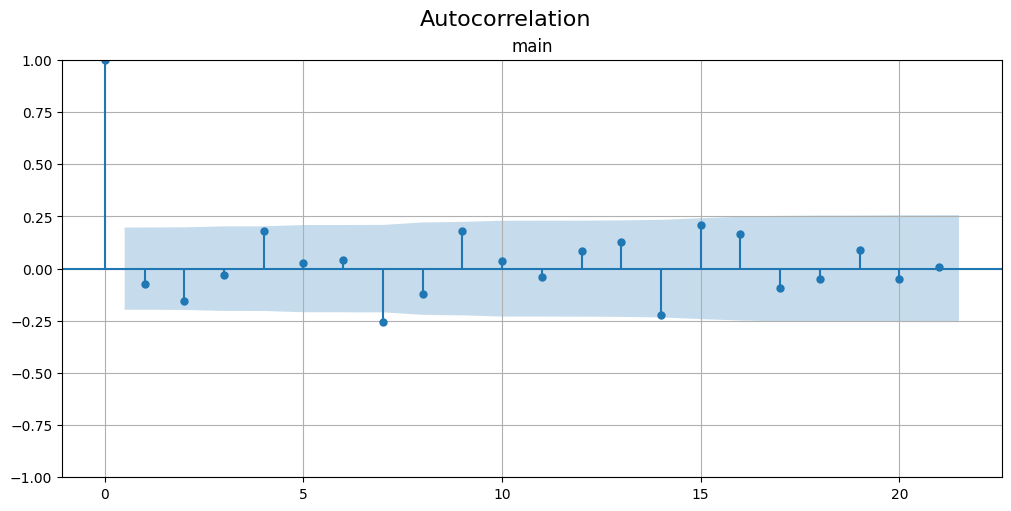

In [25]:
acf_plot(transformed_train_ts)

Значимой автокорреляции не наблюдается.

## 1.8. Финальная модель

Построим финальную модели, учитывая все полученные знания о данных.

In [26]:
pipeline = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        DensityOutliersTransform(in_column="target", window_size=5),
    ],
    model=LinearPerSegmentModel()
)
metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, 
    metrics=[MAE(), MSE()], 
    n_folds=NFOLDS, 
    aggregate_metrics=True
)

metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.8s finished


,segment,MAE,MSE
0,main,4.904237,38.701036


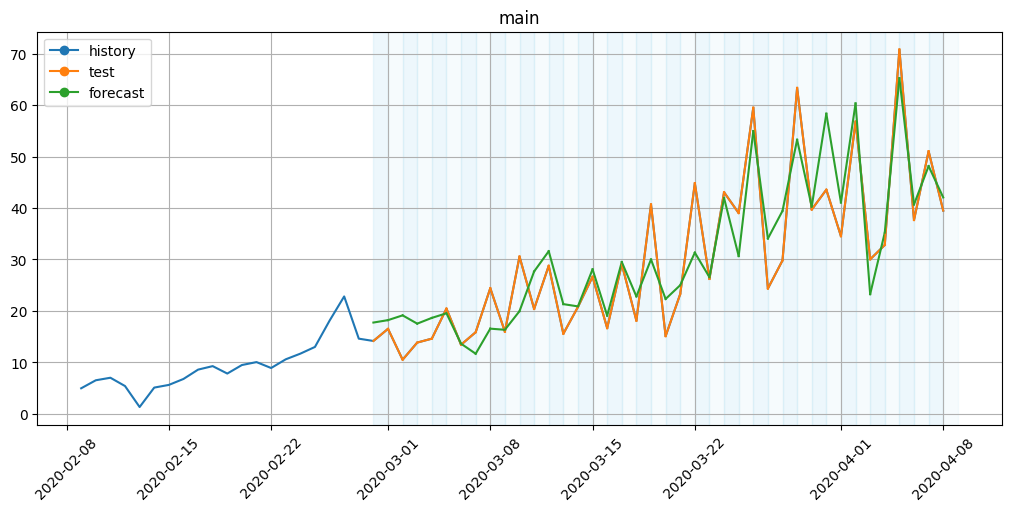

In [27]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20)

# 2. Глубинное обучение (трансформеры) для временных рядов <a class="anchor" id="chapter2"></a>
[Назад к меню](#menu)

В этой части семинара мы познакомимся с применением моделей на основе нейронных сетей, а именно трансформеров. Для этого воспользуемся связкой библиотек HuggingFace Transformers и GluonTS (аналог ETNA от Amazon, использовать будем схожим образом - для трансформации данных и создания признаков, а также создания батчей).

## 2.1. Небольшое теоретическое отступление

### 2.1.1. Глубинное обучение для временных рядов

Методы, основанные на глубинном обучении, отличаются от классических (наподобие ARIMA) по ряду отношений:
* Глобальность / локальность - классические методы, как правило, обучаются на каждом из рядов по-отдельности (при наличии нескольких). В глубинном обучении можно действовать глобально, т.е. улавливая взаимосвязи между рядами.
* Вероятностный / точечный прогноз - классические методы, как правило, дают точечный прогноз, в то время как методы глубинного обучения позволяют моделироваать распределение вероятности, а именно оптимизировать параметры распредления из заранее заданного семейства, к примеру, нормального или Стьюдента (гиперпараметр). 

Таким образом, при помощи глубинного обучения мы стремимся получить **глобальную вероятностную** модель.

### 2.1.2. Трансформерные модели для временных рядов

Временные ряды - это последовательности, поэтому логично, что трансформер с энкодер-декодерной архитектурой является естественным выбором для работы с подобным типом данных.

Заметим, что задача предсказания на несколько шагов вперед схожа с задачей генерации текста, где по заданному контексту мы сэмплируем следующий в позиции токен, и затем передаем его обратно в декодер (**авторегрессионная генерация**). В NLP такая стратегия носит название жадный поиск.

Чтобы обучить модель, нам нужно определиться с длиной контекста - в том числе исходя из соображений затрат ресурсов на вычисления и память, - а затем сэмплировать из ряда окна, состоящие из контекста (окно контекста) и последующих значений (окно предсказаний). Первое передаем в энкодер, второе - в декодер с использованием masked attention (не подглядывя вперед). Как правило, декодирование происходит по алгоритму **teacher forcing** - после токо, как мы сгенерировали значение и посчитали на нем ошибку, сравнив с ground truth, мы обучаем декодер генерировать следующее значение исходя из ground truth значения.

Одним из преимуществ архитектуры является то, что мы с легкостью можем обрабатывать пропущенные значения (частая проблема временных рядов) без необходимости ломать голову над стратегией заполнения. Это делается при помощи дополнительной маски, схожей по смыслу с `attention_mask` в NLP, которая, напомним, используется для исключения padding токенов из расчета матрицы attention.

Но нельзя не упомянуть и недостатки - квадратичные требования по ресурсам в классической модели (для решения этой проблемы придуманы различные вариации - Informer, Pyraformer и тд), а также склонность к переобучению на шум из-за большого количества параметров по сравнению с количеством данных, имеющихся обычно в распоряжении.

## 2.2. Загрузка датасета

Мы будем использовать датасет `tourism_monthly`, который является частью репозитория [Monash Time Series Forecasting](https://forecastingdata.org/), ставшего бенчмарком в области временных рядов, наподобие GLUE для задач NLP. <br>

Хочется отметить, что Monash University, крупнейший университет Австралии, занимает сильные позиции в анализе временных рядов, и помимо репозитория сотрудники университета являются авторами знаменитого учебника [Forecasting: Principles and Practice](https://otexts.com/fpp3/), доступного онлайн

Датасет же можно скачать напрямую с Hugging Face Hub:

In [10]:
dataset = load_dataset("monash_tsf", "tourism_monthly")
dataset

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/366 [00:00<?, ? examples/s]

Dataset monash_tsf downloaded and prepared to /Users/andreiegorov/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

Каждый отдельный пример состоит из ряд связанных сущностей, из которых `start` и `target` являются самыми важными:

`start` - начальная точка (в формате datetime)<br>
`target` - непосредственные значения

In [11]:
train_example = dataset["train"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [12]:
print(train_example["start"])
print(train_example["target"])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

Валидационная выборка содержит все те же данные, что и тренировочная, но с добавлением / длиннее на `prediction_length`. Тестовая, в свою очередь, на `prediction_length` длиннее валидационной.

In [13]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

Проверим, что начальные значения идентичны тренировочным

In [14]:
print(validation_example["start"])
print(validation_example["target"])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

Проверим, что пример из валидации длиннее на `prediction_length=24`, чем пример из трейна:

In [15]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

Изобразим на графике:

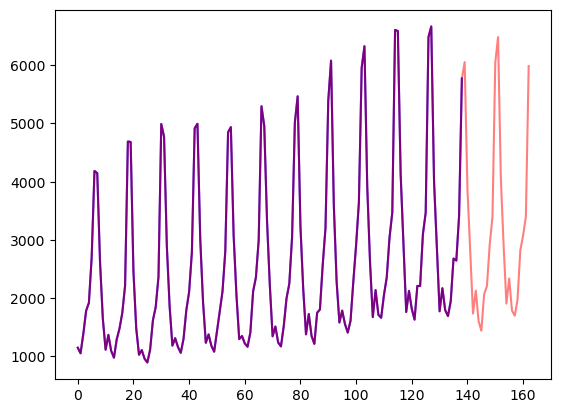

In [16]:
figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

Разобьем наши данные:

In [17]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

Далее произведем следующее необходимое техническое преобразование - сконвертируем признак `start` в объект типа `pd.Period` (дополнительно нужно задать `freq`)

In [18]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

При помощи `datasets`' [`set_transform`](https://huggingface.co/docs/datasets/v2.7.0/en/package_reference/main_classes#datasets.Dataset.set_transform) применим ко всем данным:

In [19]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

Parameter 'transform'=functools.partial(<function transform_start_field at 0x7f83321c8320>, freq='1M') of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


## 2.3. Задание модели

Обучать будем с нуля, поэтому вместо привычного `from_pretrained` инициализируем веса случайно при помощи объекта [`config`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerConfig).

В него необходимо передать следующие параметры:
- `prediction_length` (в нашем случае `24` месяца): горизонт предсказания декодера
- `context_length`: глубина ряда на вход энкодеру; по умолчанию равен `prediction_length`, если не указано иначе;
- `lags` - лаги (см. прошлый семинар);
- количество time features: в нашем случае `2`, так как мы добавляем `MonthOfYear` и `Age`; #что значит age???
- количество статических категориальных признаков (не меняющихся с течением времени): в нашем случае всего `1`, так как мы используем единственный признак такого типа "time series ID";
- cardinality: список, состоящий из мощностей множеств возможных значений каждого из статических категориальных признаков; в нашем случае список из одного элемента  `[366]`, так как в нашем распоряжении 366 различных рядов - по числу регионов страны
- размерность эмбеддинга: список, состоящий из размерностей эмбеддингов для каждого статического категориального признака; в нашем случае, к примеру, `[2]` будет означать,  что каждый ряд (регион) будет кодироваться вектором размерности `2`

Из параметров трансформера, пожалуй, напомнить можно разве что о:<br>
d_model is the dimensionality of the representations used as input to the multi-head attention, which is the same as the dimensionality of the output. In the case of normal transformers, d_model is the same size as the embedding size (i.e. 512). This naming convention comes from the original Transformer paper.

Теоретически тут можно поговорить про глобальность / локальность

Можно использовать стандартные лаги, которые GluonTS автоматически рассчитывает для данной частоты данных ("monthly"):

In [20]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


А также time features по умолчанию:

In [21]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x7f83317ac3b0>]


Получили всего один time feauture признак, а именно "month of year". (`1` для "январь", `2` для "февраль" и тд.). Впоследствии будет добавлен еще один - "age", но об этом позже??? А почему сразу не сказать???

Теперь в нашем распоряжении есть все необходимое для задания модели:

In [22]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length * 2,
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1, #("month of year" и "age")
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    embedding_dimension=[2],
    
    #параметры трансформера:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

Заметим, что модель [`TimeSeriesTransformerModel`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerModel) соответствует трансформеру с энкодер-декодерной архитектурой без какой бы то ни было "головы" на выходе, в то время как [`TimeSeriesTransformerForPrediction`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction) соответствует `TimeSeriesTransformerModel` с добавлением на выходе **distribution head**. По умолчанию используется распределение Стьюдента (можно изменить):

In [23]:
model.config.distribution_output

'student_t'

В этом месте довольно явно проявляется различие с типичными трансформерными моделями для задач NLP, где выход традиционно является дискретным распределением над определенным алфавитом, и реализуется посредством `nn.Linear`.
<br>
Здесь же модель выучивает распределение, из которого впоследствии мы можем сэмплировать, и не выдает значения как таковые напрямую.
<br>
contains the sampled values from the chosen distribution

## 2.4. Преобразования данных и генерация признаков

Используем GluonTS -- определим объект `Chain`, в который поместим преобразования так же, как делаем это с `torchvision.transforms.Compose` для изображений.

Пайплайн ниже довольно технический, но не сложный -- для читаемости блоки отделены друг от друга и снабжены комментариями

In [24]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # формируем список полей для удаления
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # сродни torchvision.transforms.Compose
    return Chain(
        # шаг 1: удаляем поля, занесенные в список для удаления
        [RemoveFields(field_names=remove_field_names)]
        # шаг 2: переводим данные в numpy формат
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # предусмотрим дополнительную размерность на случай, 
                # если работаем с многомерными рядами:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # шаг 3: заполняем NaN в таргете нулями
            # и вазвращаем маску observed_values
            # FALSE для пропущенных значений, TRUE иначе
            # маска учитывется декодером (значение функции потерь по unobserved игнорируется)
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # шаг 4: добавляем temporal features на основе частотности данных
            # месяц года в нашем случае (freq="M")
            # такие признаки служат своего рода positional encoding'ами
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # шаг 5: добавляем еще temporal feature
            # число, которое будет указывать модели на абсолютную позицию значения
            # во временном ряде
            # своего рода счетчик, сквозная нумерация
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # шаг 6: стэкаем temporal features по вертикали на ключ FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: переименовываем поля для соответствия HuggingFace обозначениям
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## 2.5. Даталоадеры

### 2.5.1. `InstanceSplitter`

Стандартная процедура создания dataloader'ов в нашем случае, к сожалению, несколько усложняется - нужно создать промежуточный `InstanceSplitter`

Он необходим для сэмплирования "окон" из датасета (длины `context_length` и длины следующего за ним `prediction_length`), а также добавления в них соответствующих меток `past_` и `future_`. Таким образом `values` распадутся на `past_values` и следующие за ними `future_values`, и будут служить входами для энкодера и декодера соответственно.

In [25]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

### 2.5.2. Непосредственно создание даталоадеров

Настало время создать даталоадеры, и таким образом иметь в распоряжении батчи (input, output) - то есть, другим словами, (`past_values`, `future_values`).

In [26]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)

    # инициализируем Instance для трейна
    instance_splitter = create_instance_splitter(config, "train") + SelectFields(
        TRAINING_INPUT_NAMES
    )

    # будет проводиться случайное сэмплирование подспоследовательностей длины
    # длина контекста + максимальное значение лага + горизонт предсказания
    # (из всех 366 преобразованных индивидуальных рядов)
    # и возвращает итератор.
    # максимальное значение лага фигурирует тут постольку, поскольку для лагов нужна доп. глубина
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data),
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )

    # имея итератор для трейн датасета, мы получаем Dataloader
    # который будет сэмплировать случайные окна в количестве batch_size
    # и, собственно, содержать тензоры, готорые для подачи в модель
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )

In [28]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # создадим Instance для теста, который будет брать сэмплы из последних
    # в каждом ряде окон контекста с тем, чтобы передавать их исключительно в энкодер
    instance_sampler = create_instance_splitter(config, "test") + SelectFields(
        PREDICTION_INPUT_NAMES
    )

    # применяем преобразования на тесте
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    # возвращаем даталоадер
    return DataLoader(
        IterableDataset(testing_instances), batch_size=batch_size, **kwargs
    )

In [29]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

### 2.5.3. Пробный батч и пробный forward pass

Проверим первый батч; 

Убедитесь, что все содержащиеся в нем сущности и их размерности вам понятны. Если что-то вызвает затруднения, можно свериться с [документацией](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction.forward.past_values) 

In [30]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


Вместо привычных в NLP `input_ids` и `attention_mask` мы подаем в энкодер `past_values`, `past_observed_mask`, `past_time_features` и `static_categorical_features`.

Соответственно, на вход в декодер идут `future_values` (аналог `decoder_input_ids` в NLP), `future_observed_mask` и `future_time_features`.

Пробный forward pass:

In [31]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [32]:
print("Loss:", outputs.loss.item())

Loss: 9.272175788879395


## 2.6. Обучаем модель

Задействуем модули библиотеки Accelerate, которая в автоматическом режиме поместит модель, оптимизатор и даталоадер на нужный нам `device`.

In [32]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # бэкпроп
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

9.474621772766113
7.650608539581299
7.66949462890625
7.025836944580078
7.485866546630859
7.331264495849609
7.2513251304626465
7.536921977996826
7.414426803588867
7.207052230834961
7.17730188369751
6.976973056793213
7.424074649810791
6.915823459625244
7.160864353179932
7.3245110511779785
6.847032070159912
6.5183892250061035
6.960793972015381
7.381021976470947
6.855855464935303
6.803353786468506
6.795085430145264
7.446527481079102
7.166541576385498
6.708963871002197
7.149658203125
6.57532262802124
6.904636383056641
6.856456756591797
6.807713985443115
7.269428730010986
6.9111857414245605
7.073579788208008
6.55289888381958
7.461112976074219
6.896011829376221
6.770899295806885
7.6531982421875
7.60558557510376


## 2.7. Inference

На инференсе, как и в NLP, мы используем метод `generate()`, реализующий авторегрессивную генерацию.

Под капотом мы задействуем test instance sampler, который берет сэмплы из последних в каждом ряде окон контекста для передачи в энкодер. В декодер же поступают `future_time_features`, которые исходя из своей природы известны заранее.

In [33]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

На выходе модели получаем массивы размерности (`batch_size`, `number of samples`, `prediction length`). 

В нашем случае, в процессе авторегрессионной генерации мы сэмплируем `100` различных значений для каждого из `24` месяцев прогнозного горизонта (ну и само собой это все для каждого из `64` объектов в батче):

In [34]:
forecasts[0].shape

(64, 100, 24)

Застэкав их по вертикали, мы получим прогноз для всех рядов в тестовом датасете

In [35]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


Для оценки, используем библиотеку Evaluate, в которой реализована знакомая нам с прошлого семинара метрика SMAPE, а также метрика MAPE (будем подсчитывать обе):

> MASE - Mean absolute scaled error; MAE, нормированное на ошибку прогноза наивной модели (например, повторяющей предыдущее значение) на обучающей выборке. Грубо говоря, мы хотим поместить MAE в контекст и понять, насколько мы улучшаем настолько простой бейзлайн, насколько только можно придумать

$$\text{MAPE} = \frac{MAE}{MAE_{in-sample, naive}}$$

In [36]:
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1) #берем медианное значение сэмплов

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [37]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.3007629355291246


In [38]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.16230864651073434


Зададим вспомогательную функцию для отрисовки результатов прогнозирования:

In [40]:
def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2 * prediction_length :],
        test_dataset[ts_index]["target"][-2 * prediction_length :],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

Например:

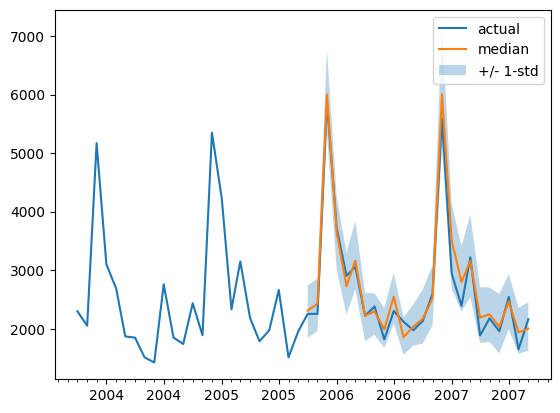

In [41]:
plot(334)

Сравним наши результаты с результатами других методов по MASE (содержатся на [Monash Time Series Repository](https://forecastingdata.org/#results))

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet| 	**Transformer** (Our) |
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|
|Tourism Monthly | 	3.306 |	1.649 |	1.751 |	1.526|	1.589|	1.678	|1.699|	1.582	| 1.409	| 1.574|	1.482	|  **1.256**|

Наша модель демонстрируем лучший результат из всех при том, что мы даже не занимались настройкой гиперпараметров. Все, что мы делали, это обучали трансформер в течение 40 эпох.

## Дополнительные материалы

Туториал по GluonTS [тут](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#What-is-in-a-dataset?). <br> Туториал по Hugging Face datasets для временных рядов [тут](https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb).